# Using STAC for searching and compiling geospatial data

This notebook presents a basic example of how to access the Copernicus Data Space Ecosystem STAC catalog to fetch and load relevant Sentinel-2 data. 

We want Sentinel-2 level 2C data, which have been orthirectified, re-projected onto WGS84 coordinate reference system (CRS), and corrected for atmospheric warping.


In [95]:
import json
import geojson
from pathlib import Path

from dotenv import load_dotenv
import geopandas as gpd
import pandas as pd
import numpy as np
from pystac_client import Client
from stacchip.chipper import Chipper
import folium
import matplotlib.pyplot as plt
from geoarrow.pyarrow import io
import pyarrow as pa
import shapely

from src import stac_filter_utils as sfu
from src.modify_sentinel2_indexer import ModSentinel2Indexer
from src.io_utils import load_indexer

### Add Environment variables
You must register an account to for access to the Copernicus S3 bucket. Registering an account can be found [here](https:#documentation.dataspace.copernicus.eu/APIs/S3.html). You will need to generate an access key after registering (also found at the above link). The access and secret keys must be saved and added as environment variables.

In [2]:
# Load environment variables
load_dotenv()

True

In [3]:
# Declare constants.
# URL = "https://stac.dataspace.copernicus.eu/v1"
STAC_API = "https://earth-search.aws.element84.com/v1" # Doesn't conform to FILTER API
COLLECTION = 'sentinel-2-l2a'
REQUIRED_ASSETS = ['red', 'green', 'blue', 'rededge1', 'rededge2', 'rededge3', 'nir', 'nir08', 'swir16', 'swir22']

In [4]:
# Load plot geometries.
dpath = Path('/Users/campbelli/Documents/mini-project/data')
plots = dpath / 'boundaries/tropical_plot_JAG_2021.geojson'
plots = geojson.load(open(plots))

## Accessing the STAC catalog
The Copernicus data store conforms (but does not declare it) to the ITEM_SEARCH STAC API spec. Use the add_conforms_to method so the pystac_client knows this server conforms. See the [pystac_client docs](https:#pystac-client.readthedocs.io/en/stable/usage.html#api-conformance) for details.

In [5]:
# Open the STAC catalog.
cat = Client.open(STAC_API)
cat.add_conforms_to("ITEM_SEARCH") # Declare STAC API ITEM_SEARCH conformance

### Searching the Catalog

Query the catalog for relevant STAC Items. Requirements:
- Intersect with plot geometry.
    - Preferably one Item captures as many of the plots as possible.
    - This could be done by counting the number of intersected plots and retaining the maximum Item.
- Little cloud cover.
- Coincident in time to the greatest extent.
    - This must be married with cloud cover requirements.
    - Could sample from one month either side, and two years either side, with temporal intersection.

### Procedure
1) Create CQL2 filters for searching the STAC catalog (must conform to the "ITEM_SEARCH" and "FILTER" STAC APIs) to be applied per plot (for loop) which:
    - Finds Items that intersect with the plot geometry.
    - Extract only those Items with cloud cover less than 10%.
    - Filter Items with time stamps within the same season (defined as ±1 month) as the time of the data collection, else in the same season in the preceding or following 2 years.
2) Apply filters and search the catalog, and return a list of up to 15 Items per plot
3) From the list of Items returned, find the Item with the time stamp closest to the data collection time stamp.
4) Find duplicates of Items and keep the Item that intersects the most plots for reducing data size requirements (prefers timestamp constraint).
5) Get CRS from the Item assets (bands) and ensure it is the same for all required bands.
6) Select the bands required.
7) Create chips.

In [6]:
# Declare filters and params universal to all plots.
cloud_cover_filter = {"op": "<", "args": [{"property": "eo:cloud_cover"}, 5]}
params = {
    "max_items": 1,
    "collections": COLLECTION,
    "sortby": "properties.eo:cloud_cover",
}

In [7]:
# items = []
# for feature in plots['features']:
#     # Add spatial and time parameters specific to the plot.
#     params['intersects'] = feature['geometry'] # Intersects with plot geometry.
#     params['filter'] = {
#         "op": "and", 
#         "args": [
#             cloud_cover_filter, # Filter Items by maximum cloud cover.
#             sfu.create_temporal_intersection_dict(feature) # Find Items in date range.
#         ]
#     }
#     items_search = list(cat.search(**params).item_collection())

#     # The STAC search doesn't know the closest timestamp, therefore we need to 
#     # select the Item with the nearest timestamp from those returned.
#     item = sfu.select_nearest_timestamp(
#         items_search, collection_timestamp=feature['properties']['datetime']
#     )
    
#     items.append(item)
#     # Add Item id to plot GeoJSON for reference.
#     feature['properties']['STAC_item_id'] = item.id
#     items = items_search

# unique_items = sfu.drop_duplicate_items(items)
# print(f"Number of unique items: {len(unique_items)}")

In [8]:
items = []
year = 2021
quartals = [
    "{year}-01-01/{year}-03-31",
    "{year}-04-01/{year}-06-30",
    "{year}-07-01/{year}-09-30",
    "{year}-10-01/{year}-12-31",
]

for feature in plots['features']:
    feature['properties']['STAC_item_id'] = []

    # Add spatial and time parameters specific to the plot.
    params['intersects'] = feature['geometry'] # Intersects with plot geometry.
    for quartal in quartals:
        item = cat.search(
            collections=COLLECTION,
            datetime=quartal.format(year=year),
            max_items=1,
            intersects=feature['geometry'] ,
            sortby="properties.eo:cloud_cover",
            query={
                # "s2:nodata_pixel_percentage": {"lte": .05},
                # "eo:cloud_cover": {"lte": 10.},
            },
        ).item_collection()

        if not item:
            print(f"No items found for {quartal.format(year=year)} in {feature['properties']["Plot_ID"]}")
            continue
    
        item = item[0]
        items.append(item)

        # Add Item id to plot GeoJSON for reference.
        feature['properties']['STAC_item_id'].append(item.id)

unique_items = sfu.drop_duplicate_items(items)
print(f"Number of unique items: {len(unique_items)}")

No items found for 2021-01-01/2021-03-31 in DRO01
No items found for 2021-01-01/2021-03-31 in ANK01
No items found for 2021-04-01/2021-06-30 in ANK01
No items found for 2021-07-01/2021-09-30 in ANK01
No items found for 2021-01-01/2021-03-31 in ANK03
No items found for 2021-04-01/2021-06-30 in ANK03
No items found for 2021-07-01/2021-09-30 in ANK03
No items found for 2021-07-01/2021-09-30 in BOB1
No items found for 2021-07-01/2021-09-30 in BOB2
No items found for 2021-01-01/2021-03-31 in LPG-01
No items found for 2021-04-01/2021-06-30 in LPG-01
No items found for 2021-07-01/2021-09-30 in LPG-01
No items found for 2021-10-01/2021-12-31 in LPG-01
No items found for 2021-01-01/2021-03-31 in LPG-02
No items found for 2021-04-01/2021-06-30 in LPG-02
No items found for 2021-07-01/2021-09-30 in LPG-02
No items found for 2021-10-01/2021-12-31 in LPG-02
No items found for 2021-01-01/2021-03-31 in 261_10
No items found for 2021-01-01/2021-03-31 in 261_9
No items found for 2021-01-01/2021-03-31 in

In [9]:
# Define Error class for when projection is not consistent.
class InconsistentProjError(Exception):
    pass

In [10]:
import pystac
from typing import List

def get_epsg_projection(item: pystac.Item, bands: List[str]) -> int:
    """Get the EPSG code of the Item projection."""
    # Check all bands have the same projection.
    init_proj = item.assets[bands[0]].to_dict()['proj:code']
    if 'EPSG' not in init_proj:
        raise ValueError(f"Projection not EPSG: {init_proj}")
    for band in bands[1:]:
        proj = item.assets[band].to_dict()['proj:code']
        if proj != init_proj:
            raise InconsistentProjError(f"Projection inconsistent across all required bands: {proj}")
    
    return int(proj.split(':')[1])

In [11]:
for item in unique_items:
    # Get feature by matching STAC item id with item.id
    plot = next(
        (feature for feature in plots['features'] \
        if item.id in feature['properties']['STAC_item_id']), 
        None
    )
    print(f"processing {item.id}...")
    item_path = Path(f"data/items/{COLLECTION}/{item.id}/stac_item.json")
    Path(item_path).parent.mkdir(parents=True, exist_ok=True)
    if not Path(item_path).exists():
        indexer = ModSentinel2Indexer(item, chip_max_nodata=0., chip_size=49)
        index = indexer.create_index()
        index = indexer.filter_by_vegetation_cover(index)
        index = indexer.get_single_pixel(index)

        # Save Item geoJson for creating the indexer at a later date.
        with open(item_path, 'w') as f:
            geojson.dump(item.to_dict(), f)

    # Save index table as geoparquet file.
    index_path = f"data/index/{COLLECTION}/{item.id}/index_{item.id}.parquet"
    Path(index_path).parent.mkdir(parents=True, exist_ok=True)

    if not Path(index_path).exists():
        with pa.OSFile(index_path, 'wb') as f:
            io.write_geoparquet_table(index, f)

processing S2A_55KCB_20210222_0_L2A...
processing S2A_55KCB_20210506_0_L2A...
processing S2B_55KCB_20210730_0_L2A...
processing S2A_55KCB_20211003_0_L2A...
processing S2B_55LCC_20210610_0_L2A...
processing S2B_55LCC_20210819_0_L2A...
processing S2A_55LCC_20211003_0_L2A...
processing S2A_30NWL_20211222_0_L2A...
processing S2A_30NXN_20210126_0_L2A...
processing S2A_30NXN_20210426_0_L2A...
processing S2A_30NXN_20211222_0_L2A...
processing S2A_22LCJ_20210331_0_L2A...
processing S2B_22LCJ_20210604_1_L2A...
processing S2B_22LCJ_20210724_1_L2A...
processing S2A_22LCJ_20211017_0_L2A...
processing S2B_21MYS_20210630_0_L2A...
processing S2A_21MYS_20210807_0_L2A...
processing S2A_21MYS_20211013_0_L2A...
processing S2B_21MYS_20210809_0_L2A...
processing S2B_18LZL_20210529_0_L2A...
processing S2A_18LZL_20210723_0_L2A...
processing S2A_19LBG_20210723_0_L2A...
Loading scl band
Dropped 6/50176 chips due to nodata above 0.0
Dropped 6930/50170 chips due to no vegetation cover
processing S2A_19LBG_202110

In [50]:
import random

# sample 10000 examples from pyarrow index
# Generate random indices for sampling
index = data.to_table()
sample_indices = random.sample(range(index.num_rows), 10000)

# Take the rows corresponding to the sampled indices
index_subsample = index.take(sample_indices)

In [53]:
df = index_subsample.to_pandas()
df['geometry'] = df['geometry'].apply(lambda x: wkb.loads(x, hex=True))
df['pixel_geometry'] = df['pixel_geometry'].apply(lambda x: wkb.loads(x, hex=True))
gdf = gpd.GeoDataFrame(df, geometry='geometry')

In [24]:
gdf[(gdf['y_pixel'] <= indexer.shape[1]) | (gdf['x_pixel'] <= indexer.shape[0])].shape == gdf.shape

True

In [ ]:
stac_items_path = Path("/Users/campbelli/Documents/geofm-plant-traits/data/items")
item_id = gdf.iloc[0]['item_id']
indexer = load_indexer(stac_items_path, platform=COLLECTION, item_id=item_id)

In [27]:
chipper = Chipper(indexer, assets=REQUIRED_ASSETS)
# chip = chipper.chip(gdf.loc[1, 'x_pixel'], gdf.loc[1, 'y_pixel'])

In [ ]:
chipper.chip(gdf.loc[2, 'x_pixel'], gdf.loc[2, 'y_pixel'])

{'red': array([[[102]]], dtype=uint16),
 'green': array([[[183]]], dtype=uint16),
 'blue': array([[[105]]], dtype=uint16),
 'rededge1': array([[[527]]], dtype=uint16),
 'rededge2': array([[[1684]]], dtype=uint16),
 'rededge3': array([[[2160]]], dtype=uint16),
 'nir': array([[[1587]]], dtype=uint16),
 'nir08': array([[[2364]]], dtype=uint16),
 'swir16': array([[[1153]]], dtype=uint16),
 'swir22': array([[[508]]], dtype=uint16)}

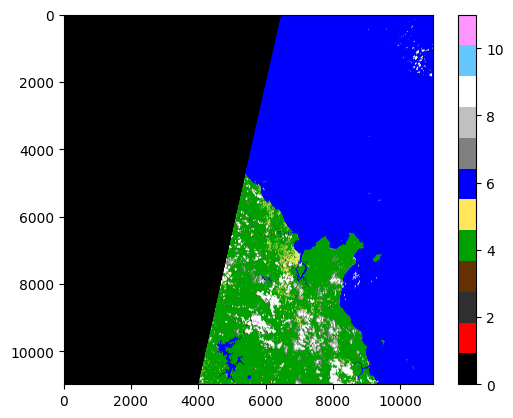

In [16]:
# Plot scene classification with corresponding colours.
classes = {
  0: [0, 0, 0], # No Data (Missing data) - black 
  1: [255, 0, 0], # Saturated or defective pixel - red 
  2: [47, 47, 47], # Topographic casted shadows ("Dark features/Shadows" for data before 2022-01-25) - very dark grey
  3: [100, 50, 0], # Cloud shadows - dark brown
  4: [0, 160, 0], # Vegetation - green
  5: [255, 230, 90], # Not-vegetated - dark yellow
  6: [0, 0, 255], # Water (dark and bright) - blue
  7: [128, 128, 128], # Unclassified - dark grey
  8: [192, 192, 192], # Cloud medium probability - grey
  9: [255, 255, 255], # Cloud high probability - white
  10: [100, 200, 255], # Thin cirrus - very bright blue
  11: [255, 150, 255], # Snow or ice - very bright pink
}

# Create a colour map for imshow for the scene classification.
from matplotlib.colors import ListedColormap
colour_map = ListedColormap(
    # 'scene_classification',
    [tuple([c / 255 for c in rgb]) for rgb in classes.values()]
)

plt.imshow(indexer.scl, cmap=colour_map, vmin=0, vmax=len(classes)-1)
plt.colorbar()

In [49]:
from pyarrow import dataset as ds
from shapely import wkb

part = ds.partitioning(field_names=["item_id"])
data = ds.dataset(
    f"data/index/{COLLECTION}/",
    format="parquet",
    partitioning=part,
)
df = data.to_table().to_pandas()
df['geometry'] = df['geometry'].apply(lambda x: wkb.loads(x, hex=True))
df['pixel_geometry'] = df['pixel_geometry'].apply(lambda x: wkb.loads(x, hex=True))
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf

chipid        date  chip_index_x  \
0          S2A_18LZL_20210723_0_L2A-0-0  2021-07-23             0   
1          S2A_18LZL_20210723_0_L2A-1-0  2021-07-23             1   
2          S2A_18LZL_20210723_0_L2A-3-0  2021-07-23             3   
3          S2A_18LZL_20210723_0_L2A-5-0  2021-07-23             5   
4          S2A_18LZL_20210723_0_L2A-6-0  2021-07-23             6   
...                                 ...         ...           ...   
502023  S2B_55LCC_20210819_0_L2A-52-223  2021-08-19            52   
502024  S2B_55LCC_20210819_0_L2A-53-223  2021-08-19            53   
502025  S2B_55LCC_20210819_0_L2A-58-223  2021-08-19            58   
502026  S2B_55LCC_20210819_0_L2A-59-223  2021-08-19            59   
502027  S2B_55LCC_20210819_0_L2A-60-223  2021-08-19            60   

        chip_index_y  cloud_cover_percentage  nodata_percentage  \
0                  0                     0.0                0.0   
1                  0                     0.0                0.0   
2                  0                     0.0                0.0   
3                  0                     0.0                0.0   
4                  0                     0.0                0.0   
...              ...                     ...                ...   
502023           223                     0.0                0.0   
502024           223                     0.0                0.0   
502025           223                     0.0                0.0   
502026           223                     0.0                0.0   
502027           223                     0.0                0.0   

                                                 geometry  \
0       POLYGON ((-72.234 -12.64964, -72.23395 -12.654...   
1       POLYGON ((-72.2295 -12.64959, -72.22945 -12.65...   
2       POLYGON ((-72.22048 -12.6495, -72.22043 -12.65...   
3       POLYGON ((-72.21147 -12.6494, -72.21142 -12.65...   
4       POLYGON ((-72.20696 -12.64935, -72.20691 -12.6...   
...                                                   ...   
502023  POLYGON ((145.37067 -16.35815, 145.37064 -16.3...   
502024  POLYGON ((145.37526 -16.35819, 145.37522 -16.3...   
502025  POLYGON ((145.39819 -16.35836, 145.39816 -16.3...   
502026  POLYGON ((145.40278 -16.3584, 145.40274 -16.36...   
502027  POLYGON ((145.40736 -16.35843, 145.40733 -16.3...   

        vegetated_percentage  x_pixel  y_pixel  \
0                        1.0       -3       -1   
1                        1.0       52        2   
2                        1.0      137      -11   
3                        1.0      255        3   
4                        1.0      284       -9   
...                      ...      ...      ...   
502023                   1.0     2545    10939   
502024                   1.0     2592    10918   
502025                   1.0     2852    10924   
502026                   1.0     2891    10936   
502027                   1.0     2928    10932   

                                           pixel_geometry  \
0       POLYGON ((-72.2364632526433 -12.65173946440039...   
1       POLYGON ((-72.23140137131533 -12.6519578643418...   
2       POLYGON ((-72.22359571793844 -12.6507022333102...   
3       POLYGON ((-72.21272841217308 -12.6518533205383...   
4       POLYGON ((-72.21007279182754 -12.6507415151239...   
...                                                   ...   
502023  POLYGON ((145.36812081282756 -16.3613868215664...   
502024  POLYGON ((145.3725356202901 -16.3595232080935,...   
502025  POLYGON ((145.39686646411843 -16.3602520188963...   
502026  POLYGON ((145.400507957407 -16.361364157932094...   
502027  POLYGON ((145.40397405320414 -16.3610289664580...   

                         item_id  
0       S2A_18LZL_20210723_0_L2A  
1       S2A_18LZL_20210723_0_L2A  
2       S2A_18LZL_20210723_0_L2A  
3       S2A_18LZL_20210723_0_L2A  
4       S2A_18LZL_20210723_0_L2A  
...                          ...  
502023  S2B_55LCC_20210819_0_L2A  
502024  S2B_55LCC_20210819_0_L2A  
502025  S2B_55LCC

In [ ]:
# Find chips in gdf that intersect with the first plot.
gdf = gpd.GeoDataFrame.from_arrow(index)
plot_geom = plot['geometry']
mask = gdf.apply(lambda x: sfu.intersection_percent(x, plot_geom), axis=1) > 0.
gdf[mask]

In [ ]:
# Check all pixel geometires wholly within chip geometry.
gdf = gpd.GeoDataFrame.from_arrow(index)
# pixel_geom = gdf['pixel_geometry']
mask = gdf.apply(lambda x: sfu.intersection_percent(x, pixel_geom), axis=0) > 0.
gdf[mask]

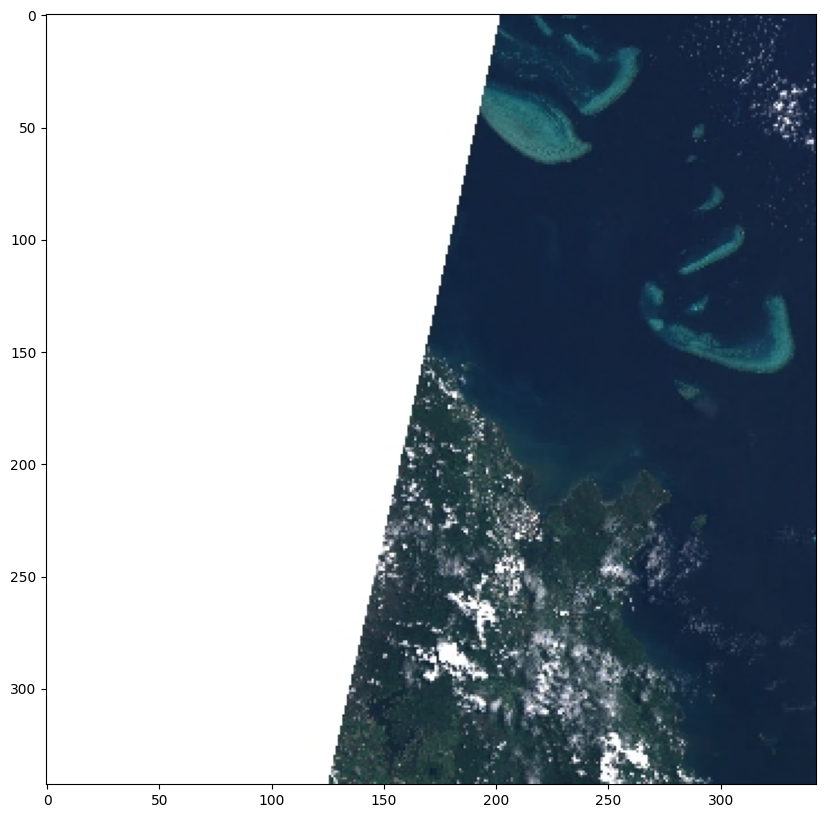

In [19]:
# Load the thumbnail from url and plot it.
import requests
from PIL import Image
from io import BytesIO

fig, axs = plt.subplots(1, 1, figsize=(10, 10))
url = item.assets['thumbnail'].href
response = requests.get(url)
img = Image.open(BytesIO(response.content))
axs.imshow(img)

In [190]:
item

<Item id=S2B_50NNL_20210420_0_L2A>

/var/folders/g5/h0yjdszs0pz_qr3k5z8bjjq80000gp/T/ipykernel_26211/635846402.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


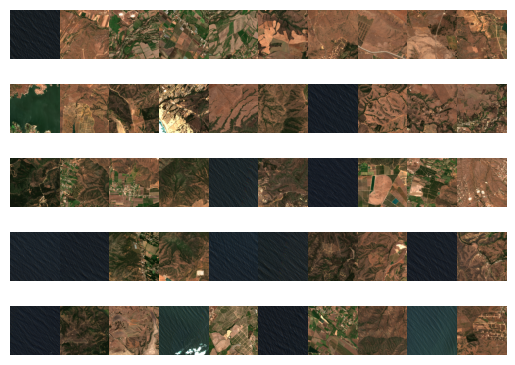

In [ ]:
fig, axs = plt.subplots(5, 10, gridspec_kw={'wspace': 0.01, 'hspace': 0.01}, squeeze=True)

random_chips = gdf.sample(50)
for i, ax in enumerate(axs.flatten()):
    x = random_chips.iloc[i]['chip_index_x']
    y = random_chips.iloc[i]['chip_index_y']
    ax.imshow(chipper.chip(x, y)['TCI_10m'][:3].swapaxes(0, 1).swapaxes(1, 2))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [54]:
geoms = list(gdf.loc[:, 'pixel_geometry'])
geoms = shapely.geometry.MultiPolygon(geoms)
geoms = shapely.to_geojson(geoms)

In [55]:
# Pick coordinates from first plot in plots.
# Reverse the coordinates for Folium api
start_loc = plots['features'][0]['geometry']['coordinates'][0][2][::-1]

# Create map centred on first plot.
m = folium.Map(start_loc, zoom_start=8)
folium.GeoJson(plots).add_to(m)

folium.GeoJson(geoms,
    style_function=lambda feature: {
    "fillColor": "#ffff00",
    "color": "black",
    "weight": 2,
    "dashArray": "5, 5",
    }
).add_to(m, name='chips')
# folium.GeoJson(item.geometry).add_to(m, name='item')

folium.LayerControl().add_to(m)
m

In [ ]:
tmp_gdf = gdf.set_index('chipid')
df = pd.DataFrame(
    np.zeros((gdf.shape[0], len(REQUIRED_ASSETS))),
    columns=REQUIRED_ASSETS,
    index=gdf.chipid
)

In [101]:
tmp_gdf

date  chip_index_x  chip_index_y  \
chipid                                                                     
S2A_19LDF_20210511_0_L2A-124-18   2021-05-11           124            18   
S2A_19LDF_20210511_0_L2A-181-56   2021-05-11           181            56   
S2B_55LCC_20210610_0_L2A-22-208   2021-06-10            22           208   
S2A_55KCB_20210222_0_L2A-116-200  2021-02-22           116           200   
S2B_21MYS_20210630_0_L2A-33-43    2021-06-30            33            43   
...                                      ...           ...           ...   
S2B_21MYS_20210630_0_L2A-13-189   2021-06-30            13           189   
S2A_21MYS_20211013_0_L2A-149-45   2021-10-13           149            45   
S2A_19LDF_20210121_0_L2A-100-72   2021-01-21           100            72   
S2B_18LZL_20210529_0_L2A-93-56    2021-05-29            93            56   
S2A_19LDF_20210511_0_L2A-184-102  2021-05-11           184           102   

                                  cloud_cover_percentage  nodata_percentage  \
chipid                                                                        
S2A_19LDF_20210511_0_L2A-124-18                      0.0                0.0   
S2A_19LDF_20210511_0_L2A-181-56                      0.0                0.0   
S2B_55LCC_20210610_0_L2A-22-208                      0.0                0.0   
S2A_55KCB_20210222_0_L2A-116-200                     0.0                0.0   
S2B_21MYS_20210630_0_L2A-33-43                       0.0                0.0   
...                                                  ...                ...   
S2B_21MYS_20210630_0_L2A-13-189                      0.0                0.0   
S2A_21MYS_20211013_0_L2A-149-45                      0.0                0.0   
S2A_19LDF_20210121_0_L2A-100-72                      0.0                0.0   
S2B_18LZL_20210529_0_L2A-93-56                       0.0                0.0   
S2A_19LDF_20210511_0_L2A-184-102                     0.0                0.0   

                                                                           geometry  \
chipid                                                                                
S2A_19LDF_20210511_0_L2A-124-18   POLYGON ((-69.35734 -12.74352, -69.35735 -12.7...   
S2A_19LDF_20210511_0_L2A-181-56   POLYGON ((-69.10011 -12.91212, -69.10011 -12.9...   
S2B_55LCC_20210610_0_L2A-22-208   POLYGON ((145.23369 -16.29063, 145.23365 -16.2...   
S2A_55KCB_20210222_0_L2A-116-200  POLYGON ((145.6586 -17.16228, 145.65857 -17.16...   
S2B_21MYS_20210630_0_L2A-33-43    POLYGON ((-55.05118 -2.90311, -55.05117 -2.907...   
...                                                                             ...   
S2B_21MYS_20210630_0_L2A-13-189   POLYGON ((-55.13814 -3.55014, -55.13813 -3.554...   
S2A_21MYS_20211013_0_L2A-149-45   POLYGON ((-54.54009 -2.91096, -54.54008 -2.915...   
S2A_19LDF_20210121_0_L2A-100-72   POLYGON ((-69.46611 -12.98262, -69.46612 -12.9...   
S2B_18LZL_20210529_0_L2A-93-56    POLYGON ((-71.81182 -12.8927, -71.81177 -12.89...   
S2A_19LDF_20210511_0_L2A-184-102  POLYGON ((-69.08663 -13.11595, -69.08663 -13.1...   

                                  vegetated_percentage  x_pixel  y_pixel  \
chipid                                                                     
S2A_19LDF_20210511_0_L2A-124-18                    1.0     6072      883   
S2A_19LDF_20210511_0_L2A-181-56                    1.0     8865     2736   
S2B_55LCC_20210610_0_L2A-22-208                    1.0     1083    10187   
S2A_55KCB_20210222_0_L2A-116-200                   1.0     5689     9806   
S2B_21MYS_20210630_0_L2A-33-43                     1.0     1608     2104   
...                                                ...      ...      ...   
S2B_21MYS_20210630_0_L2A-13-189                    1.0      627     9252   
S2A_21MYS_20211013_0_L2A-149-45                    1.0     7299     2194   
S2A_19LDF_20210121_0_L2A-100-72                    1.0     4905     3540   
S2B_18LZL_20210529_0_L2A-93-56                     1.0 

In [105]:
# tqdm for progress bar
from tqdm import tqdm

In [118]:
chippers = {}
stac_items_path = Path("/Users/campbelli/Documents/geofm-plant-traits/data/items")

for item_id in tmp_gdf.groupby('item_id').groups.keys():
    indexer = load_indexer(stac_items_path, platform=COLLECTION, item_id=item_id)
    chippers[item_id] = Chipper(indexer, assets=REQUIRED_ASSETS)

In [120]:
for item_id, chipper in chippers.items():
    pixels = tmp_gdf[tmp_gdf['item_id'] == item_id]
    print(f"processing {item_id}...")
    for chipid in tqdm(pixels.index):
        if df.loc[chipid, :].sum() > 0:
            continue
        x, y = pixels.loc[chipid, ['x_pixel', 'y_pixel']]
        band_vals = chipper.chip(x, y)
        df.loc[chipid, :] = [v.item() for v in band_vals.values()]

processing S2A_18LZL_20210723_0_L2A...


100%|██████████| 229/229 [00:00<00:00, 24703.47it/s]


processing S2A_19LBG_20210723_0_L2A...


100%|██████████| 892/892 [00:00<00:00, 39777.15it/s]


processing S2A_19LBG_20211021_0_L2A...


100%|██████████| 808/808 [00:00<00:00, 49346.19it/s]


processing S2A_19LDF_20210121_0_L2A...


100%|██████████| 657/657 [35:07<00:00,  3.21s/it]


processing S2A_19LDF_20210511_0_L2A...


100%|██████████| 697/697 [00:00<00:00, 35432.51it/s]


processing S2A_21MYS_20210807_0_L2A...


100%|██████████| 148/148 [06:13<00:00,  2.52s/it]


processing S2A_21MYS_20211013_0_L2A...


100%|██████████| 606/606 [33:27<00:00,  3.31s/it]


processing S2A_22LCJ_20210331_0_L2A...


100%|██████████| 431/431 [24:25<00:00,  3.40s/it]


processing S2A_22LCJ_20211017_0_L2A...


100%|██████████| 55/55 [03:21<00:00,  3.66s/it]


processing S2A_30NWL_20211222_0_L2A...


100%|██████████| 273/273 [14:02<00:00,  3.09s/it]


processing S2A_30NXN_20210126_0_L2A...


100%|██████████| 134/134 [07:09<00:00,  3.20s/it]


processing S2A_30NXN_20210426_0_L2A...


100%|██████████| 75/75 [04:21<00:00,  3.48s/it]


processing S2A_30NXN_20211222_0_L2A...


100%|██████████| 302/302 [16:01<00:00,  3.18s/it]


processing S2A_55KCB_20210222_0_L2A...


100%|██████████| 37/37 [01:51<00:00,  3.02s/it]


processing S2A_55KCB_20210506_0_L2A...


100%|██████████| 305/305 [1:31:00<00:00, 17.90s/it]   


processing S2A_55KCB_20211003_0_L2A...


100%|██████████| 169/169 [08:24<00:00,  2.99s/it]


processing S2A_55LCC_20211003_0_L2A...


100%|██████████| 169/169 [08:05<00:00,  2.87s/it]


processing S2B_18LZL_20210529_0_L2A...


100%|██████████| 241/241 [12:05<00:00,  3.01s/it]


processing S2B_19LDF_20210913_0_L2A...


100%|██████████| 801/801 [1:17:40<00:00,  5.82s/it]   


processing S2B_21MYS_20210630_0_L2A...


100%|██████████| 785/785 [37:15<00:00,  2.85s/it]


processing S2B_21MYS_20210809_0_L2A...


100%|██████████| 718/718 [33:54<00:00,  2.83s/it]


processing S2B_22LCJ_20210604_1_L2A...


100%|██████████| 216/216 [10:19<00:00,  2.87s/it]


processing S2B_22LCJ_20210724_1_L2A...


100%|██████████| 115/115 [05:36<00:00,  2.93s/it]


processing S2B_50NNL_20210420_0_L2A...


100%|██████████| 695/695 [32:50<00:00,  2.84s/it]


processing S2B_55KCB_20210730_0_L2A...


100%|██████████| 210/210 [09:46<00:00,  2.79s/it]


processing S2B_55LCC_20210610_0_L2A...


100%|██████████| 136/136 [06:01<00:00,  2.66s/it]


processing S2B_55LCC_20210819_0_L2A...


100%|██████████| 96/96 [04:31<00:00,  2.83s/it]


In [122]:
df.to_csv('data.csv')

In [189]:
import rasterio
import numpy as np

def extract_pixels_optimized(raster_path, pixel_coordinates):
    """
    Extract values using optimized numpy indexing
    """
    # Load entire raster
    with rasterio.open(raster_path) as src:
        raster_data = src.read(1)
    
    # Convert coordinates to arrays for faster indexing
    y_coords = np.array([y for _, y in pixel_coordinates], dtype=np.int32)
    x_coords = np.array([x for x, _ in pixel_coordinates], dtype=np.int32)
    
    # Extract all values in a single operation
    values = raster_data[y_coords, x_coords]
    
    return values

In [ ]:
def read_files():
    with rasterio.open(srcpath) as src:
    # Currently assume that different assets may be at different
    # resolutions, but are aligned and the gsd differs by an integer
    # multiplier.
    if self.indexer.shape[0] % src.height:
        raise ValueError(
            f"Asset height {src.height} is not a multiple of highest resolution height {self.indexer.shape[0]}"  # noqa: E501
        )

    if self.indexer.shape[1] % src.width:
        raise ValueError(
            f"Asset width {src.width} is not a multiple of highest resolution width {self.indexer.shape[1]}"  # noqa: E501
        )

    factor = self.indexer.shape[0] / src.height

    chip_window = Window(
        math.floor(x * self.indexer.chip_size / factor),
        math.floor(y * self.indexer.chip_size / factor),
        math.ceil(self.indexer.chip_size / factor),
        math.ceil(self.indexer.chip_size / factor),
    )

    return src.read(
        window=chip_window,
        out_shape=(src.count, self.indexer.chip_size, self.indexer.chip_size),
        resampling=Resampling.nearest,
    )

In [ ]:
def get_pixels_for_asset(self, key: str, x: int, y: int) -> ArrayLike:
    """
    Extracts chip pixel values for one asset.

    Args:
        key (str): The asset key to extract pixels from.
        x (int): The x index of the chip.
        y (int): The y index of the chip.

    Returns:
        ArrayLike: Array of pixel values for the specified asset.

    Raises:
        ValueError: If asset dimensions are not multiples of the highest resolution dimensions.
    """
    asset = self.indexer.item.assets[key]

    srcpath = asset.href
    if self.mountpath:
        url = urlparse(srcpath, allow_fragments=False)
        srcpath = self.mountpath / Path(url.path.lstrip("/"))



In [187]:
def euclidean_distance(df):
    mean_spectrum = df.mean(axis=0)
    return ((df - mean_spectrum)**2).mean(axis=1) ** 0.5

<Axes: ylabel='Density'>

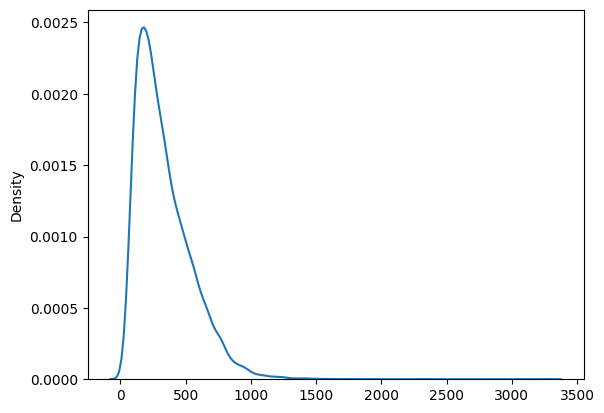

In [188]:
import seaborn as sns
sns.kdeplot(euclidean_distance(df))

In [184]:
CENTRAL_WAVELENTGHS = {
    'B2': 490,
    'B3': 560,
    'B4': 665,
    'B5': 705,
    'B6': 740,
    'B7': 783,
    'B8': 842,
    'B8a': 864,
    'B11': 1610,
    'B12': 2190
}
wavelengths = [wv for wv in CENTRAL_WAVELENTGHS.values()]

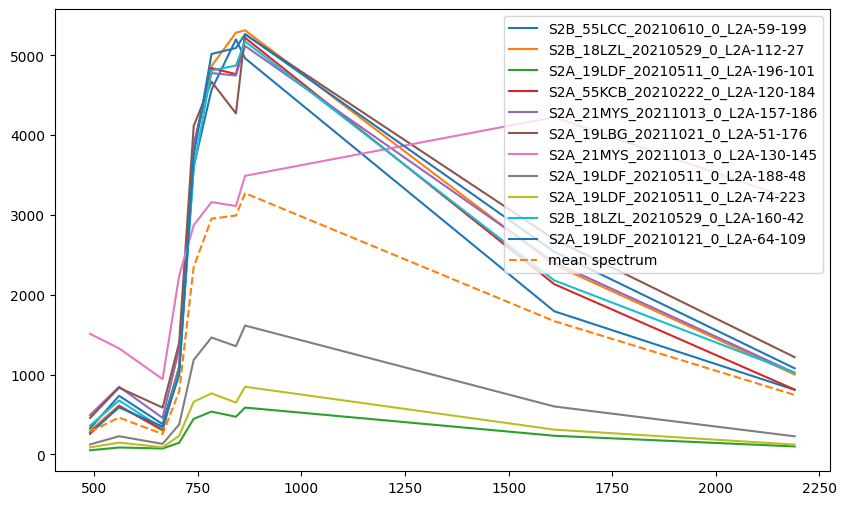

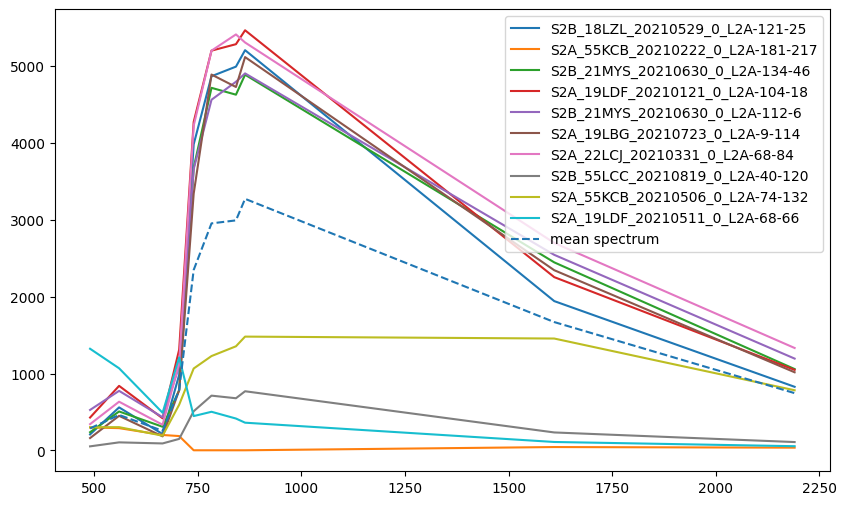

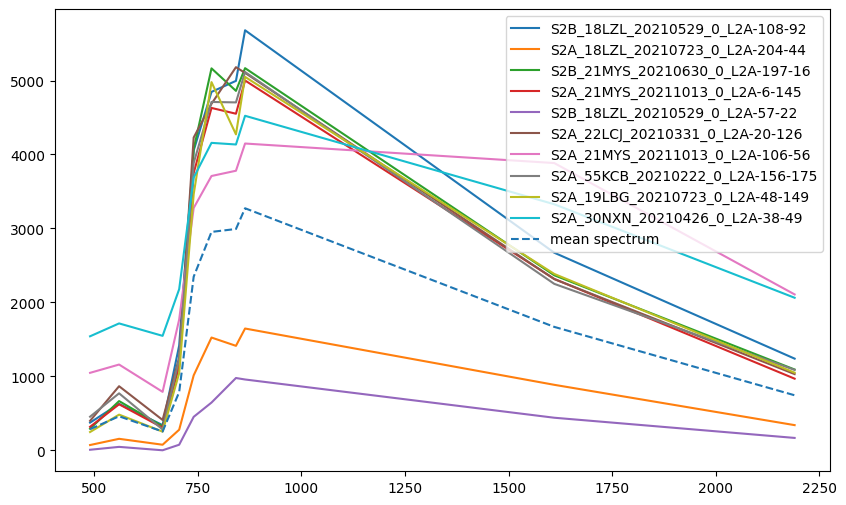

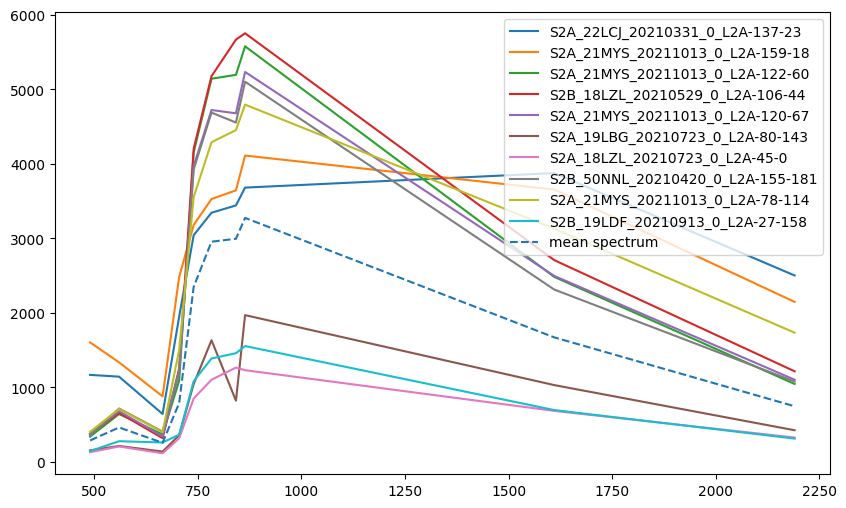

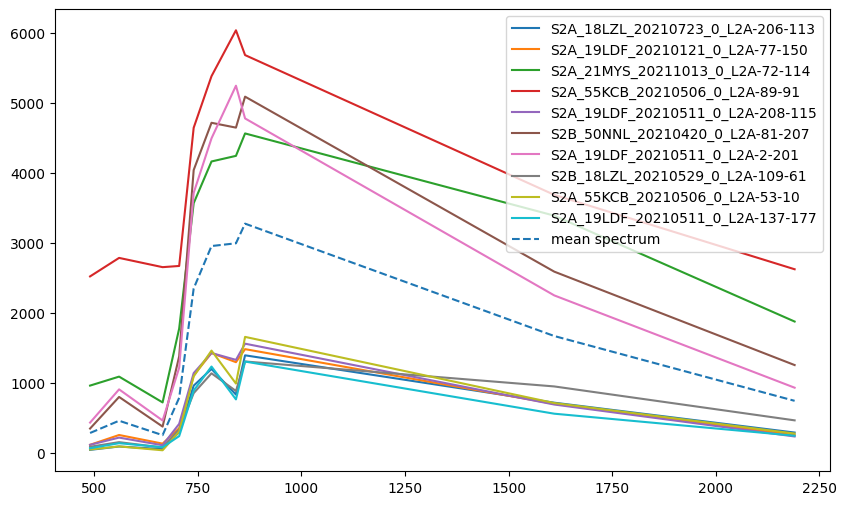

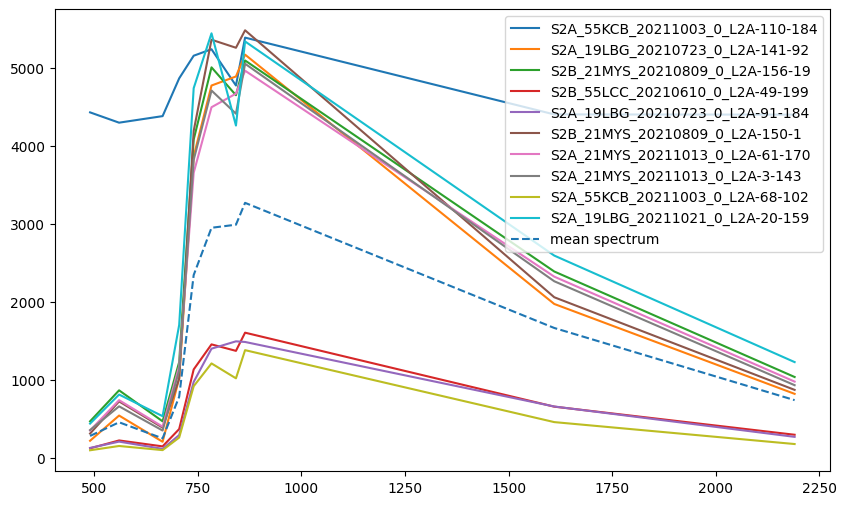

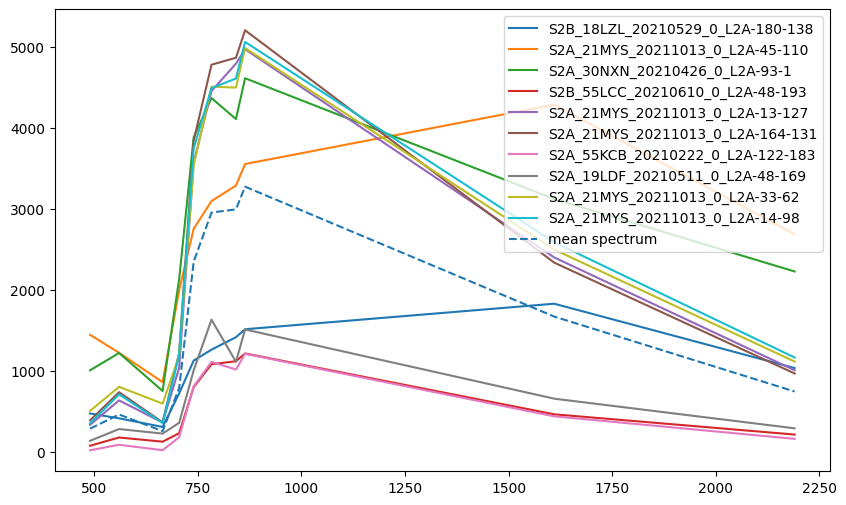

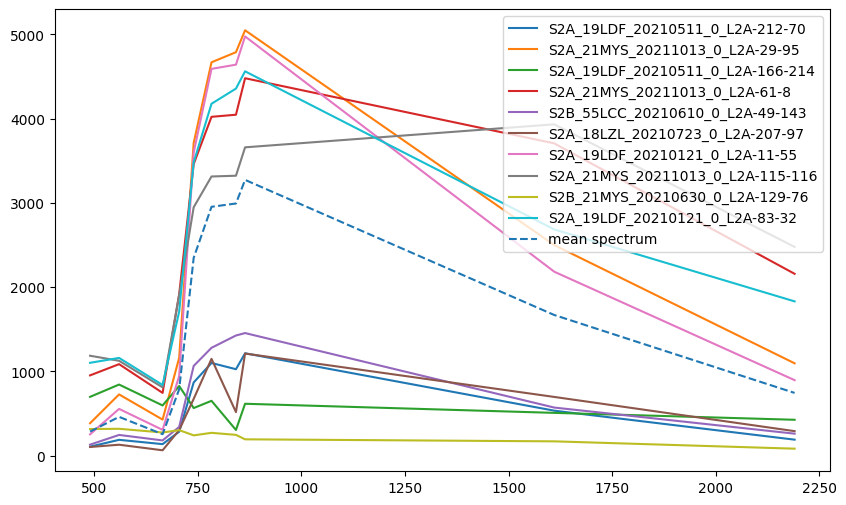

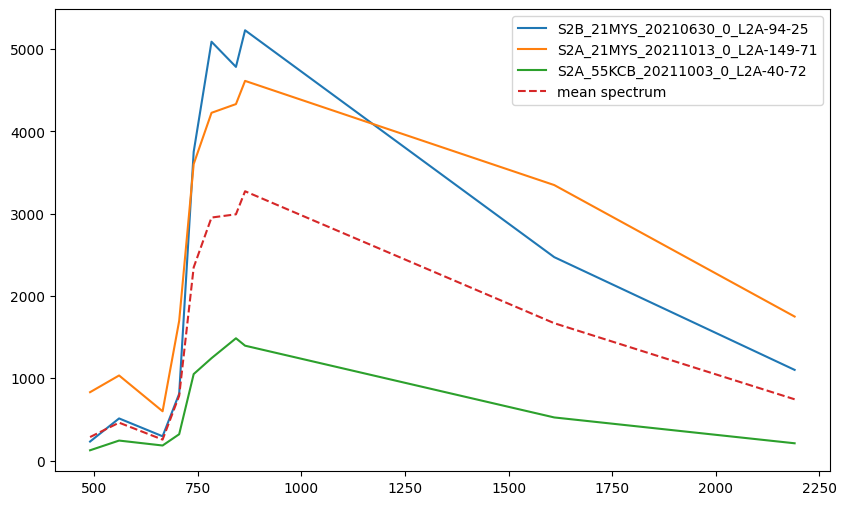

In [185]:
outliers = df[euclidean_distance(df) > 1000]
mean_spectrum = df.mean(axis=0)
plt.figure(figsize=(10,6))

for i, id in enumerate(euclidean_distance.index):
    plt.plot(wavelengths, euclidean_distance.loc[id, :], label=id)
    if i != 0 and i % 10 == 0:
        plt.plot(wavelengths, mean_spectrum, linestyle='--', label='mean spectrum')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10,6))
    
    if i == len(euclidean_distance)-1:
        plt.plot(wavelengths, mean_spectrum, linestyle='--', label='mean spectrum')
        plt.legend()
        plt.show()
